# Logistic Regression -- Weight Confidence Intervals

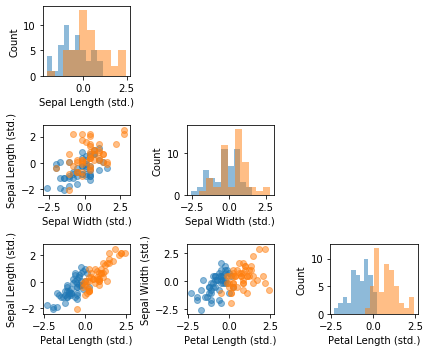

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.plotting import scatterplotmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy import stats
import numpy as np


iris = load_iris()


X_train, y_train = iris.data[50:150, :3], iris.target[50:150]
y_train = np.array(50*[0] + 50*[1])

sc_features = StandardScaler()
sc_target = StandardScaler()

X_std = sc_features.fit_transform(X_train)

fig, axes = scatterplotmatrix(X_std[y_train==0], figsize=(6, 5), alpha=0.5)
fig, axes = scatterplotmatrix(X_std[y_train==1], fig_axes=(fig, axes), alpha=0.5,
                              names=['Sepal Length (std.)','Sepal Width (std.)', 'Petal Length (std.)'])

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd

df1 = pd.DataFrame(X_std)
df2 = pd.DataFrame(y_train)

df = pd.concat((df1, df2), axis=1)
df.columns = ['sepal length', 'sepal width', 'petal length', 'species']

df.to_csv('data.csv', index=None)

## Weight coefficients

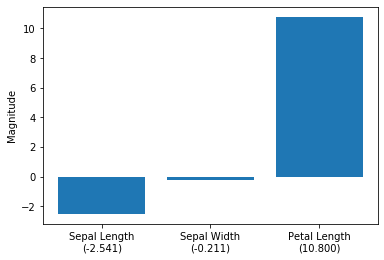

In [3]:
lor = LogisticRegression(random_state=0, solver='newton-cg', C=1e8)

# set C=1e8 to negate regularization to allow comparison with
# statsmodel coefficients later

lor.fit(X_std, y_train)

fig, ax = plt.subplots()
ax.bar([0, 1, 2], lor.coef_.flatten())

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f'Sepal Length\n({lor.coef_.flatten()[0]:.3f})',
                    f'Sepal Width\n({lor.coef_.flatten()[1]:.3f})',
                    f'Petal Length\n({lor.coef_.flatten()[2]:.3f})'])
plt.ylabel('Magnitude')
plt.show()

In [4]:
print('train accuracy', lor.score(X_std, y_train))

train accuracy 0.95


In [5]:
def std_err_logisticregression(y_true, y_pred_proba, X):
    # based on code from 
    # https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

    # Design matrix -- add column of 1's at the beginning of your X_train matrix
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
    V = np.diagflat(np.product(y_pred_proba, axis=1))

    # Covariance matrix
    cov = np.linalg.inv(X_design.T @ V @ X_design)

    # Standard errors:
    std_errs = np.sqrt(np.diag(cov))
    
    return std_errs


def weight_intervals(n, weight, std_err, alpha=0.05):
    t_value = stats.t.ppf(1 - alpha/2, df=n - 2)
    temp = t_value * std_err
    lower = weight - temp
    upper = weight + temp

    return lower, upper

In [6]:
y_pred_proba = lor.predict_proba(X_std)
std_err = std_err_logisticregression(y_train, y_pred_proba, X_std)

lower, upper = weight_intervals(len(y_train), lor.coef_.flatten(), std_err[1:])

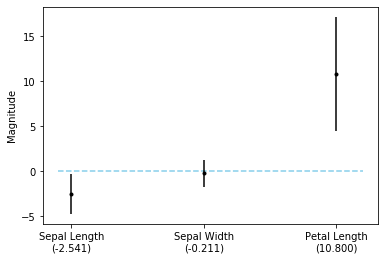

In [7]:
fig, ax = plt.subplots()

ax.hlines(0, xmin=-0.1, xmax=2.2, linestyle='dashed', color='skyblue')
ax.errorbar([0, 1, 2], lor.coef_.flatten(), yerr=upper - lor.coef_.flatten(), fmt='.k')

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f'Sepal Length\n({lor.coef_.flatten()[0]:.3f})',
                    f'Sepal Width\n({lor.coef_.flatten()[1]:.3f})',
                    f'Petal Length\n({lor.coef_.flatten()[2]:.3f})'])
plt.ylabel('Magnitude');

In [8]:
lower, upper

(array([-4.77771221, -1.71641308,  4.43242151]),
 array([-0.30375066,  1.2935979 , 17.16730293]))

---

In [9]:
import statsmodels.api as sm


model = sm.Logit(y_train, X_std)
res = model.fit(method='ncg')
lower, upper = res.conf_int(0.05)[:, 0], res.conf_int(0.05)[:, 1]

Optimization terminated successfully.
         Current function value: 0.120691
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 20
         Hessian evaluations: 10


In [10]:
lower, upper

(array([-4.78965224, -1.62105453,  4.48828742]),
 array([-0.40139451,  1.25645007, 16.7429816 ]))

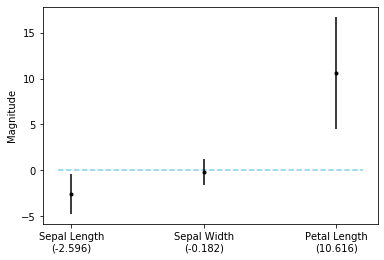

In [11]:
fig, ax = plt.subplots()

ax.hlines(0, xmin=-0.1, xmax=2.2, linestyle='dashed', color='skyblue')
ax.errorbar([0, 1, 2], res.params, yerr=upper - res.params, fmt='.k')

ax.set_xticks([0, 1, 2])
ax.set_xticklabels([f'Sepal Length\n({res.params[0]:.3f})',
                    f'Sepal Width\n({res.params[1]:.3f})',
                    f'Petal Length\n({res.params[2]:.3f})'])
plt.ylabel('Magnitude');